# Weather Impact on Agricultural Commodity Prices

Importing necessary libraries:

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from dotenv import load_dotenv

Add root directory to PATH:

In [2]:
module_path = Path().cwd().parent.as_posix()
if module_path not in sys.path:
    sys.path.append(module_path)

Importing custom functions and modules:

In [3]:
from src.price import get_commodity_data
from src.noaa import noaa_batch_data_extraction
from src.nasa import nasa_batch_data_extraction
from src.utils import load_price, data_prep
from src.data_prep import preprocess_data, save_cleaned_data
from src.data_viz import plot_time_series, plot_spectral_analysis, plot_ecm_adjustment
from src.analysis import test_stationarity, fit_arima_model, error_correction_model, regression_model, create_regression_table, rolling_window_validation

Autoreload on update:

In [4]:
%load_ext autoreload
%autoreload 2

Load environment variables from .env file:

In [5]:
load_dotenv(override=True)

True

Define and create (if not exists) data folder:

In [6]:
DATA_FOLDER = Path().cwd().parent / 'data'
DATA_FOLDER.mkdir(parents=True, exist_ok=True)

Define research time span:

In [7]:
START, END = "2010-01-01", "2025-01-01"

## Step 1: Define Commodity Pairs for Analysis.

We have selected the following commodities for analysis:

| Commodity  | Ticker | Main Production States          | Refined Product                     | Closely Related Product |
| ---------- | ------ | ------------------------------- | ----------------------------------- | ----------------------- |
| Corn       | ZC     | Iowa, Illinois, Nebraska        | Corn Oil (ZO)                       | Wheat (ZW)              |
| Soybeans   | ZS     | Illinois, Iowa, Minnesota       | Soybean Oil (ZL), Soybean Meal (ZM) | Rapeseed/Canola (None)  |
| Lean Hogs  | HE     | Iowa, North Carolina, Minnesota | Pork Bellies (None)                 | Live Cattle (LE)        |
| Dairy/Milk | DC     | Wisconsin, California, New York | Cheese (None), Butter (CB)          | None                    |

Below is the dictionary with tickers information:

In [15]:
# Define ticker dictionary.
TICKERS = {
    'Corn': 'ZC=F',
    'Corn Oil': 'ZO=F',
    'Wheat': 'ZW=F',
    'Soybean': 'ZS=F',
    'Soybean Oil': 'ZL=F',
    'Soybean Meal': 'ZM=F',
    'Live Cattle': 'LE=F',
    'Lean Hogs': 'HE=F',
    'Dairy/Milk': 'DC=F',
    'Butter': 'CB=F'
}

In [16]:
# Storing the tickers dictionary locally.
# with open(Path.cwd().parent / 'lib' / 'tickers.json', 'w') as fp:
#     json.dump(TICKERS, fp)

## Step 2: Extract Commodity Prices.

In [34]:
# Extarct data.
commodity_data = get_commodity_data(
    tickers = TICKERS.values(),
    start_date=START,
    end_date=END,
  )

YF.download() has changed argument auto_adjust default to True


In [35]:
# Quick check.
commodity_data[list(TICKERS.values())[0]]

,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,418.50,426.25,413.25,415.75,140553
2010-01-05,418.75,420.00,415.25,417.25,80967
2010-01-06,421.75,422.00,416.00,418.00,96453
2010-01-07,417.50,424.00,414.50,421.00,137395
2010-01-08,423.00,423.75,415.00,417.50,137395
...,...,...,...,...,...
2024-12-24,448.50,448.75,446.75,447.25,88153
2024-12-26,453.75,454.25,448.50,448.50,176165
2024-12-27,454.00,455.00,452.25,453.25,162024


In [36]:
# Save to file.
for ticker in list(TICKERS.values()):
    commodity_data[ticker].to_csv(DATA_FOLDER / 'price' / f'price_{ticker}.csv', sep=';')

## Step 3: Define Locations and Extract Weather Data.

### NOAA data extraction

To download data from NOAA website the API token is needed, one can get it [here](<https://www.ncdc.noaa.gov/cdo-web/token>). API documentation can be accessed via this [link](<https://www.ncdc.noaa.gov/cdo-web/webservices/v2#gettingStarted>).
                                                                                                                                                                
Additional information on using NOAA API can be found in hthe "Medium" blog post [NOAA Climate API](<https://medium.com/@markwkiehl/noaa-climate-api-c2e36e7a49c5>)  by Mark W Kiehl.

Let's specify parameters first (FIPS codes are provided [here](https://www.weather.gov/pimar/FIPSCodes)):

In [20]:
# Make sure that NOAA_TOKEN is set in the environment.
API_TOKEN  = os.getenv("NOAA_API_TOKEN")

# Get start and end years.
START_YEAR = datetime.strptime(START, '%Y-%m-%d').date().year
END_YEAR = datetime.strptime(END, '%Y-%m-%d').date().year

# Dwfine state to FIPS mappings (see API documentation).
STATE_FIPS = {
    "Iowa": "FIPS:19",
    "Illinois": "FIPS:17",
    "Nebraska": "FIPS:31",
    "Minnesota": "FIPS:27",
    "North Carolina": "FIPS:37",
    "Wisconsin": "FIPS:55",
    "California": "FIPS:06",
    "New York": "FIPS:36",
}

# NOAA API details.
DATASET_ID = "GHCND"
DATATYPES = ["TMIN", "TMAX", "PRCP"]  # min-max temperatures and precipitation
HEADERS = {"token": API_TOKEN}

The function below searches for weather stations for each state, selects those having data for the year of intereset and saves to file. The number of stations per state which gonna be used for data extraction is limited to 20 for the sake of efficiency.

In [21]:
noaa_batch_data_extraction(
    state_fips=STATE_FIPS,
    syear=START_YEAR,
    eyear=END_YEAR,
    dsid=DATASET_ID,
    dtys=DATATYPES,
    data_folder=DATA_FOLDER / 'noaa',
    headers=HEADERS,
    max_stations_per_state=20
)


Processing Iowa (FIPS:19)
Fetching stations, offset=1
  Retrieved 154 records
Fetching stations, offset=1001
  Retrieved 0 records
  Found 154 stations
Preselecting best 20 stations from 154 total stations...
[1/154] Getting history for GHCND:USC00113455
  Station GHCND:USC00113455 active 1938-01-01 to 2025-04-20 - Coverage: 1
[2/154] Getting history for GHCND:USC00117391
  Station GHCND:USC00117391 active 1866-02-01 to 2025-04-19 - Coverage: 1
[3/154] Getting history for GHCND:USC00130112
  Station GHCND:USC00130112 active 1894-03-01 to 2024-12-31 - Coverage: 1
[4/154] Getting history for GHCND:USC00130133
  Station GHCND:USC00130133 active 1893-01-01 to 2025-04-19 - Coverage: 1
[5/154] Getting history for GHCND:USC00130149
  Station GHCND:USC00130149 active 1902-06-01 to 2025-04-19 - Coverage: 1
[6/154] Getting history for GHCND:USC00130157
  Station GHCND:USC00130157 active 1914-02-01 to 2025-04-17 - Coverage: 1
[7/154] Getting history for GHCND:USC00130200
  Station GHCND:USC00130

### NASA POWER data extraction

NASA POWER API documentation can be accessed via the following [link](<https://power.larc.nasa.gov/docs/tutorials/service-data-request/api/>). Using this API is also discussed in the following "Medium" blog post [Weather Data at Your Fingertips: A Beginner’s Guide to NASA POWER API in Python](https://medium.com/@aadiray/weather-data-at-your-fingertips-a-beginners-guide-to-nasa-power-api-in-python-d62b7cff8922).

Geographical coordinates for US States where taken from this [source](<https://www.latlong.net/category/states-236-14.html>).

In [20]:
# State centroids (latitude, longitude)
state_coords = {
    "Iowa": {"lat":42.0046,"lon":-93.2140},
    "Illinois": {"lat":40.6331,"lon":-89.3985},
    "Nebraska": {"lat":41.4925,"lon":-99.9018},
    "Minnesota": {"lat":46.7296,"lon":-94.6859},
    "North Carolina": {"lat":35.7822,"lon":-80.7935},
    "Wisconsin": {"lat":44.0682,"lon":-87.1923},
    "California": {"lat":36.7783,"lon":-119.4179},
    "New York": {"lat":43.2994,"lon":-74.2179}
}

default_params = {
    "community":"AG",
    "parameters":"T2M_MAX,T2M_MIN,PRECTOT",  # min-max temperatures and precipitation
    "format":"JSON",
    "start":f"{START_YEAR}0101",
    "end":f"{END_YEAR}1231",
    "time-standard":"UTC"
}

In [21]:
nasa_batch_data_extraction(
    state_coords=state_coords,
    data_folder=DATA_FOLDER / 'nasa',
    default_params=default_params
)

Processing Iowa (42.0046,-93.214)
Saved data for Iowa to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/nasa/Iowa_nasa_power.csv
Processing Illinois (40.6331,-89.3985)
Saved data for Illinois to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/nasa/Illinois_nasa_power.csv
Processing Nebraska (41.4925,-99.9018)
Saved data for Nebraska to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/nasa/Nebraska_nasa_power.csv
Processing Minnesota (46.7296,-94.6859)
Saved data for Minnesota to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/nasa/Minnesota_nasa_power.csv
Processing North Carolina (35.7822,-80.7935)
Saved data for North Carolina to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/nasa/North_Carolina_nasa_power.csv
Processing Wisconsin (44.0682,-87.1923)
Saved data for Wisconsin to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/nasa/Wisconsin_nasa_power.csv
Processing California (36.7783,-119.4179)
Saved data for California to 

## Step 4: Exploratory Data Analysis

Let's perform EDA for the first set of commodities along with corresponding weather data (NASA POWER data are used as they are more reliable):
- commodity: `Corn`
- refined product: `Corn Oil`
- closely related product: `Wheat`
- tickers: `ZC=F`, `ZO=F`, `ZW=F`
- main production states: `Iowa`, `Illinois`, `Nebraska`
- weather data privider: `NASA POWER`

In [37]:
# Load tickers dictionary.
with open(Path.cwd().parent / 'lib' / 'tickers.json', 'r') as fp:
    TICKERS = json.load( fp)

# Define states.
states = ['Iowa', 'Illinois', 'Nebraska']

# Load and concatenate data.
corn_data = data_prep(
    comoddities=list(TICKERS.keys())[:3],
    states=states,
    tickers_dict=TICKERS,
    data_folder=DATA_FOLDER,
    data_provider='nasa'
).set_index('date')

corn_data.index = pd.to_datetime(corn_data.index)

Preprocessing data by removing ouliers and filling missing values:

In [29]:
cleaned_df, metadata = preprocess_data(df=corn_data, states=list(map(str.lower, states)))

Starting data preprocessing...
Missing values summary:
  corn: 0.16% missing
  corn_oil: 0.11% missing
  wheat: 0.11% missing
  iowa_tmin: 0.00% missing
  iowa_tmax: 0.00% missing
  iowa_prc: 0.00% missing
  illinois_tmin: 0.00% missing
  illinois_tmax: 0.00% missing
  illinois_prc: 0.00% missing
  nebraska_tmin: 0.00% missing
  nebraska_tmax: 0.00% missing
  nebraska_prc: 0.00% missing
Processing column: corn
Winsorized 0 outliers in corn
Processing column: corn_oil
Winsorized 1 outliers in corn_oil
Processing column: wheat
Winsorized 0 outliers in wheat
Processing column: iowa_tmin
Winsorized 2 outliers in iowa_tmin
Processing column: iowa_tmax
Winsorized 1 outliers in iowa_tmax
Processing column: iowa_prc
Winsorized 115 outliers in iowa_prc
Processing column: illinois_tmin
Winsorized 1 outliers in illinois_tmin
Processing column: illinois_tmax
Winsorized 4 outliers in illinois_tmax
Processing column: illinois_prc
Winsorized 122 outliers in illinois_prc
Processing column: nebraska_tm

Saving data:

In [30]:
save_cleaned_data(cleaned_df, metadata, DATA_FOLDER / 'analysis' / 'cleaned')

Saved cleaned data to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/cleaned/corn_weather_cleaned.parquet
Saved metadata saved to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/cleaned/corn_weather_cleaned_metadata.json


First, let's look at commodity price spread depending on the waether anomalies:

Saved time series plot to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/results/time_series_corn_spread_iowa_temp_anomaly_30d.png


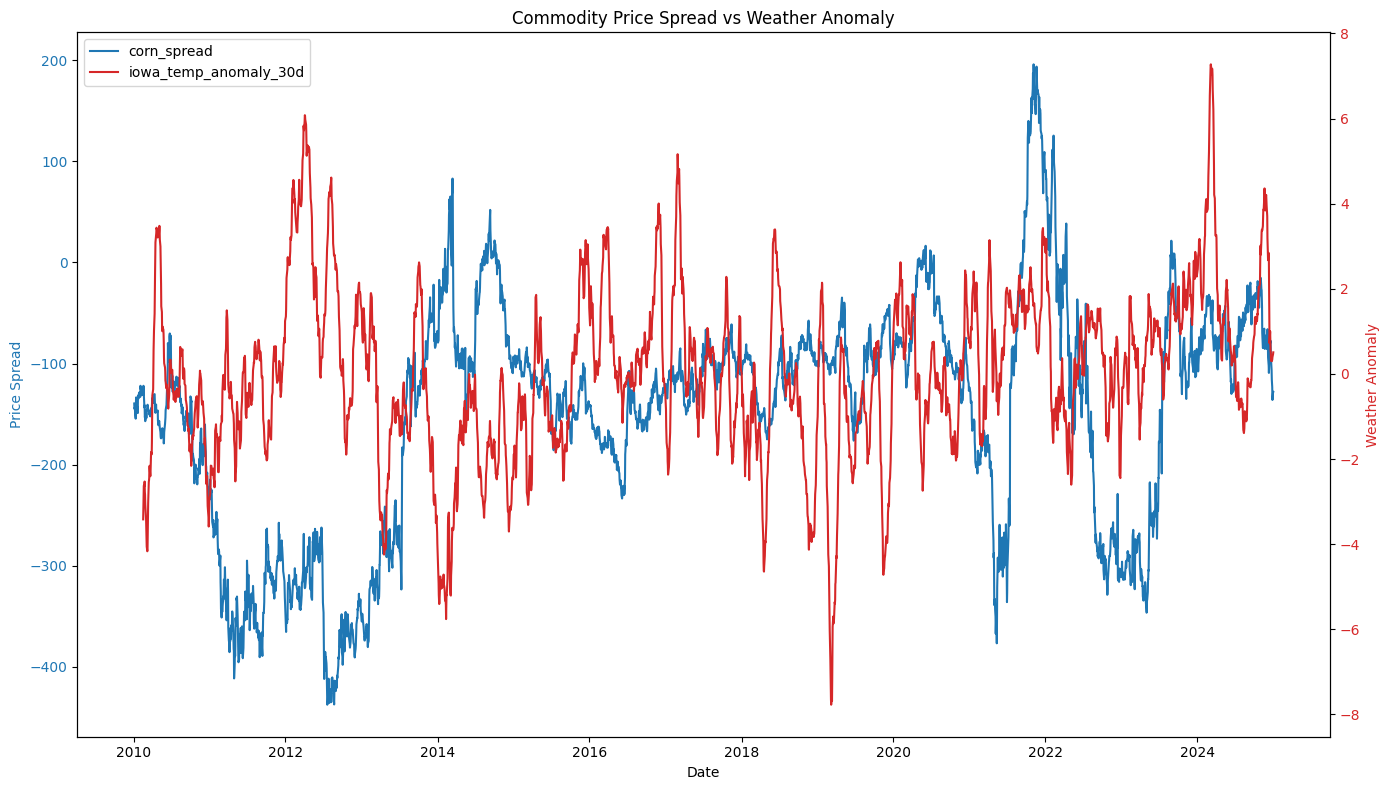

In [31]:
plot_time_series(df=cleaned_df, data_folder=DATA_FOLDER / 'analysis' / 'results')

Now let's plot spectral analysis for corn data as well:

Saved spectral analysis plot to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/results/spectral_analysis_corn_spread.png


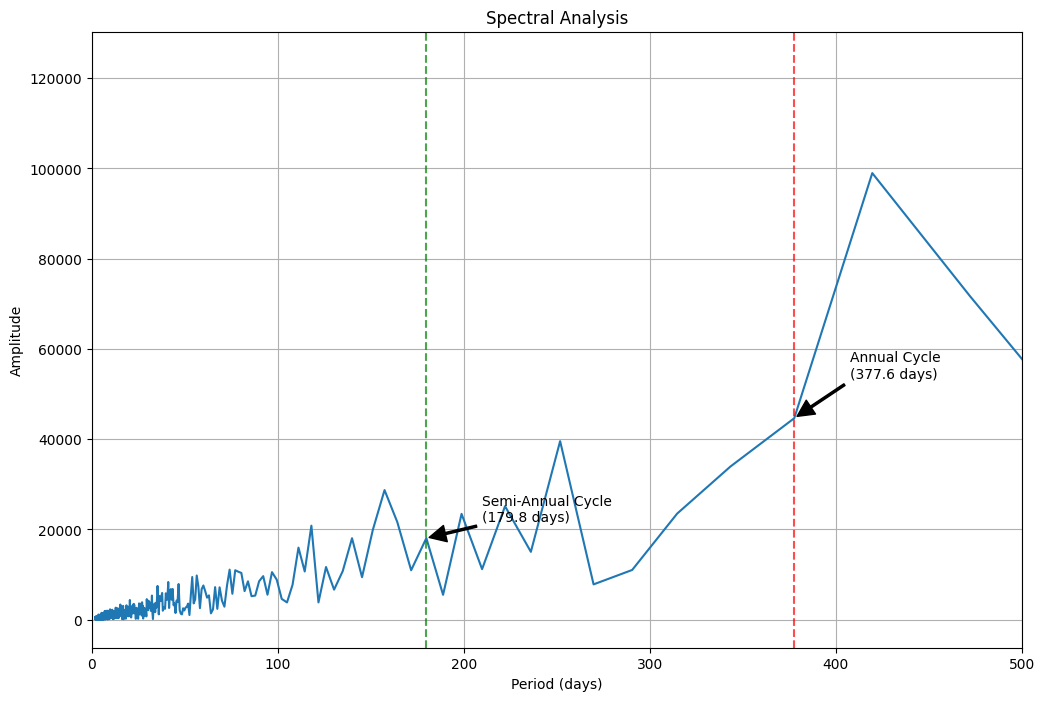

Top 5 dominant periods for corn_spread: [ 472.         3776.          419.55555556  944.         1258.66666667] days


In [32]:
dominant_periods = plot_spectral_analysis(cleaned_df, data_folder=DATA_FOLDER / 'analysis' / 'results', column='corn_spread')

Thus we see th corn-corn oil spread strongly oscillates on a six‐month and on a twelve‐month cycle - exactly what we’d expect from planting/harvest seasons.

## Step 5: Time Series Analysis

First of all we check time series stationarity wuth Augmented Dickey-Fuller test:

In [33]:
for col in ['corn', 'corn_oil', 'corn_spread']:
    if col in cleaned_df.columns:
        print(f"\nStationarity Test for {col}:")
        test_stationarity(cleaned_df[col])


Stationarity Test for corn:
ADF Statistic: -2.1779
p-value: 0.2144
Critical Values:
	1%: -3.4321
	5%: -2.8623
	10%: -2.5672
Series is non-stationary (p-value > 0.05)

Stationarity Test for corn_oil:
ADF Statistic: -2.3395
p-value: 0.1595
Critical Values:
	1%: -3.4321
	5%: -2.8623
	10%: -2.5672
Series is non-stationary (p-value > 0.05)

Stationarity Test for corn_spread:
ADF Statistic: -2.8407
p-value: 0.0527
Critical Values:
	1%: -3.4321
	5%: -2.8623
	10%: -2.5672
Series is non-stationary (p-value > 0.05)


Then apply ARIMA model for corn data:

In [34]:
# Fit ARIMA model for corn spread.
if 'corn_spread' in cleaned_df.columns:
    arima_model = fit_arima_model(cleaned_df['corn_spread'])

ADF Statistic: -2.8407
p-value: 0.0527
Critical Values:
	1%: -3.4321
	5%: -2.8623
	10%: -2.5672
Series is non-stationary (p-value > 0.05)
Series is not stationary, differencing will be applied
Best ARIMA order: (2, 1, 2) with AIC: 28495.6438
ARIMA Model Summary for corn_spread:
                               SARIMAX Results                                
Dep. Variable:            corn_spread   No. Observations:                 3776
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -14242.822
Date:                Wed, 21 May 2025   AIC                          28495.644
Time:                        00:35:13   BIC                          28526.825
Sample:                             0   HQIC                         28506.729
                               - 3776                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------

Now let's perform cointegration analysis:


Cointegration Analysis for Corn and Corn Oil:
Johansen Cointegration Test for ['corn', 'corn_oil']:
Trace Statistics:
 [17.50329701  5.35300919]
Critical Values (5%): [15.4943  3.8415]
Cointegration Rank: 2

Vector Error Correction Model (VAR on diffs) Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, May, 2025
Time:                     00:40:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.77986
Nobs:                     3774.00    HQIC:                   8.77347
Log likelihood:          -27253.0    FPE:                    6437.84
AIC:                      8.76995    Det(Omega_mle):         6427.62
--------------------------------------------------------------------
Results for equation corn
                 coefficient       std. error           t-stat            prob
-------------------------------------------

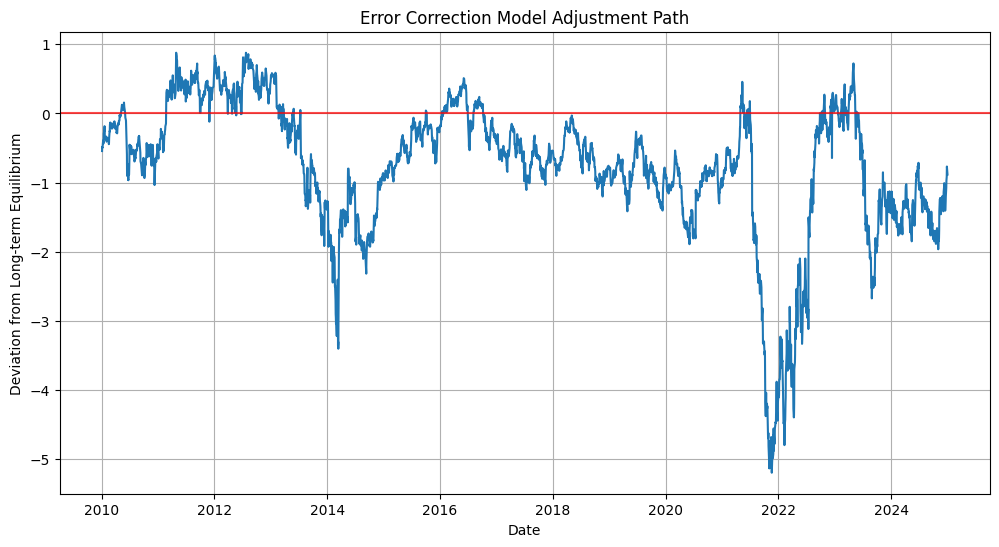

In [36]:
# Cointegration and error correction model
if all(col in cleaned_df.columns for col in ['corn', 'corn_oil']):
    print("\nCointegration Analysis for Corn and Corn Oil:")
    var_results, ec_series = error_correction_model(cleaned_df, ['corn', 'corn_oil'])

    if ec_series is not None:
        plot_ecm_adjustment(cleaned_df, DATA_FOLDER / 'analysis' / 'results', ec_series)

The cointegration analysis confirms a stable, long-term relationship between corn and corn oil prices. The Error Correction Model and its adjustment path illustrate how deviations from this equilibrium occur and how the system tends to revert back to this long-run relationship over time.

## Step 6: Regression Analysis

Let's perform regression analysis:

After searching for best set of independatn variables to fit to the model we come to a conclusion that:
1) 'iowa_prc_anomaly_30d', 'illinois_temp_anomaly_30d', 'illinois_prc_anomaly_30d', 'nebraska_temp_anomaly_30d', 'nebraska_prc_anomaly_30d' - show the most impact on target variable while being statistically significant;
2) weather conditions in the states under consideration, have very little impact on corn prices - only 1% of variance can be described by weather anomalies. It is worth noting here that only linear relationship is considered here and non-linearity should be modelled for further investigation 

In [95]:
# Regression analysis with weather variables.
if 'corn_spread' in cleaned_df.columns:
    # Define weather variables.
    # weather_vars = [col for col in cleaned_df.columns if 'anomaly' in col]
    weather_vars = ['iowa_prc_anomaly_30d', 'illinois_temp_anomaly_30d', 'illinois_prc_anomaly_30d', 'nebraska_temp_anomaly_30d', 'nebraska_prc_anomaly_30d']

    if weather_vars:
        print("\nRegression Analysis of Price Spread vs Weather Anomalies:")
        reg_results, coef_df = regression_model(cleaned_df, 'corn_spread', weather_vars, lags=0)
        create_regression_table(reg_results, DATA_FOLDER / 'analysis' / 'results',)

        # Validation.
        print("\nPerforming Rolling Window Validation:")
        validation_df, avg_metrics = rolling_window_validation(cleaned_df, DATA_FOLDER / 'analysis' / 'results', 'corn_spread', weather_vars)


Regression Analysis of Price Spread vs Weather Anomalies:
Regression Model for corn_spread:
                            OLS Regression Results                            
Dep. Variable:            corn_spread   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     79.21
Date:                Mon, 19 May 2025   Prob (F-statistic):           3.26e-79
Time:                        01:26:22   Log-Likelihood:                -22846.
No. Observations:                3747   AIC:                         4.570e+04
Df Residuals:                    3741   BIC:                         4.574e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------